In [1]:
import random
from tensorflow.keras.datasets import mnist,fashion_mnist
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
class PCA_MODEL:
    
    def __init__(self,dataset,num_compenent):
        self.dataset = dataset
        self.num_components = num_compenent
        self.eigenvector = None
        self.df_pca = None
        self.decoded_dataset = None
        self.mean = None
        
    def PCA(self,X): 
        #calculer la moyenne et la soustraire
        X_meaned = X - np.mean(X , axis = 0)
        #garder la moyenne en mémoire pour éviter les images avec une satruation de gris pour le decode
        self.mean = np.mean(X , axis = 0)
        #produire la matrice de covariance
        cov_mat = np.cov(X_meaned , rowvar = False)
        #récupérer les vecteurs et valeurs propres 
        eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
        #ordonner les vecteurs et valeurs propores
        sorted_index = np.argsort(eigen_values)[::-1]
        sorted_eigenvalue = eigen_values[sorted_index]
        sorted_eigenvectors = eigen_vectors[:,sorted_index]
        #définir le nombre de vecteurs propres à utiliser
        eigenvector_subset = sorted_eigenvectors[:,0:self.num_components]
        #réduire la dimension
        X_reduced = np.dot(eigenvector_subset.transpose() , X_meaned.transpose() ).transpose()
        print("Dim => eigenvector =",eigenvector_subset.shape)
        self.dataset = X_reduced
        self.eigenvector = eigenvector_subset
        return (X_reduced  ,eigenvector_subset)  
    
    def encode(self, pca_dataset):
        print(self.eigenvector.shape)
        X_encoded = np.dot(pca_dataset ,self.eigenvector.T)
        return X_encoded
    
    #décode le dataset de pca en utilisant les vecteurs propores
    def decode(self,pca_dataset):
        final_dataset = np.dot(self.eigenvector,pca_dataset.transpose()).transpose() + self.mean
        self.decoded_dataset = final_dataset
        return final_dataset
    
    #Prépare la dataframe à afficher à partir du dataset sorti par la PCA + la liste des colonnes et la target
    def prepare_df_pca(self, x_dataset, columns_list, y_target):
        principal_df = pd.DataFrame(x_dataset , columns =columns_list)
        principal_df = pd.concat([principal_df , pd.DataFrame(y_target,columns=['target'])] , axis = 1)
        self.df_pca  = principal_df
        return principal_df
    
    #plot la pca en choisissant 2 colonnes à afficher data_x : DataFrame préparée, x_axe : axe1, y_axe: axe2, s_value: diamètre des plots 
    def draw_pca(self,data_x, x_axe,y_axe,s_value=60, fig_size=(9,9)):
        plt.figure(figsize = fig_size)
        sb.scatterplot(data = data_x, x=x_axe, y=y_axe , hue='target' , s=s_value , palette="deep")
        plt.show()
    
    #affiche nb_samples images du dataset
    def plot(self,dataset,nb_samples,taille):
        plt.figure(figsize=(taille, taille))
        for i in range(nb_samples):
            plt.subplot(30,30,i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(dataset[i].reshape(taille, taille), cmap=plt.cm.gray)
        plt.show()
        
    #afficher des samples en 3D 
    def plot_3D(self, dataset, rndperm):
        ax = plt.figure(figsize=(16,16)).gca(projection='3d')
        ax.scatter(
            xs = dataset.loc[rndperm,:]["PC1"], 
            ys = dataset.loc[rndperm,:]["PC2"], 
            zs = dataset.loc[rndperm,:]["PC3"], 
            c = dataset.loc[rndperm,:]["target"], 
            cmap = 'tab10',
            s = 4
        )
        ax.set_xlabel('PCA 1')
        ax.set_ylabel('PCA 2')
        ax.set_zlabel('PCA 3')
        plt.show()

In [3]:
#charger dataset mnist
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(x_train.shape[0], -1)
    return x_train, y_train

#### 1-Dataset Jouet

In [4]:
#créer le jeu de donnée jouet
dataset_jouet = np.array([[3,2], [3.5,1], [4,2.5],
                         [-8,5], [-9.5,7], [-6,5.6],
                         [-11,-2], [-13.5,-1.5], [-14,-2.8]])

print(dataset_jouet.shape)

(9, 2)


#### 1.1- Application de la PCA

In [5]:
pca_jouet = PCA_MODEL(dataset_jouet,dataset_jouet.shape[1])

In [6]:
pca_dataset_jouet, vecteurs_propres_jouet = pca_jouet.PCA(dataset_jouet)
print("==>", pca_dataset_jouet)
print("==>", vecteurs_propres_jouet.shape)

Dim => eigenvector = (2, 2)
==> [[-8.62565461  1.30116134]
 [-8.95460669  2.36970733]
 [-9.6942006   0.97220926]
 [ 1.73216906 -3.46491555]
 [ 2.88328203 -5.68413589]
 [-0.33922023 -3.72825266]
 [ 5.84121903  2.94723763]
 [ 8.22513472  2.04338699]
 [ 8.93187728  3.24360154]]
==> (2, 2)


In [7]:
cols_jouet = ['PC%s'%(i+1) for i in range(dataset_jouet.shape[1])]
df_prepared_jouet = pca_jouet.prepare_df_pca(pca_dataset_jouet,cols_jouet,None)
df_prepared_jouet.sample(9)

PC1       PC2 target
7  8.225135  2.043387    NaN
8  8.931877  3.243602    NaN
5 -0.339220 -3.728253    NaN
0 -8.625655  1.301161    NaN
6  5.841219  2.947238    NaN
4  2.883282 -5.684136    NaN
2 -9.694201  0.972209    NaN
1 -8.954607  2.369707    NaN
3  1.732169 -3.464916    NaN

#### 1.2 - Plot PCA 

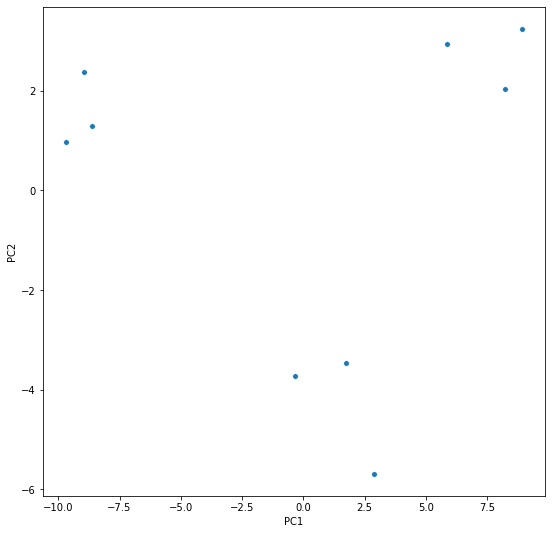

In [8]:
pca_jouet.draw_pca(df_prepared_jouet,cols_jouet[0],cols_jouet[1],30)

#### 1.3 - Décoder le dataset

In [9]:
decoded_ds_jouet = pca_jouet.decode(pca_dataset_jouet)
decoded_ds_jouet

array([[  3. ,   2. ],
       [  3.5,   1. ],
       [  4. ,   2.5],
       [ -8. ,   5. ],
       [ -9.5,   7. ],
       [ -6. ,   5.6],
       [-11. ,  -2. ],
       [-13.5,  -1.5],
       [-14. ,  -2.8]])

#### 1.4 - Tester avec la PCA du Sklearn

In [10]:
from sklearn.decomposition import PCA
pca_sk = PCA(dataset_jouet.shape[1])
pca_result_jouet = pca_sk.fit_transform(dataset_jouet)
print(pca_result_jouet)
pca_result_jouet.shape

[[ 8.62565461 -1.30116134]
 [ 8.95460669 -2.36970733]
 [ 9.6942006  -0.97220926]
 [-1.73216906  3.46491555]
 [-2.88328203  5.68413589]
 [ 0.33922023  3.72825266]
 [-5.84121903 -2.94723763]
 [-8.22513472 -2.04338699]
 [-8.93187728 -3.24360154]]


(9, 2)

Text(0, 0.5, 'PCA2')

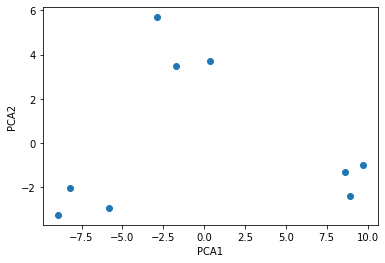

In [11]:
plt.scatter(pca_result_jouet[:, 0], pca_result_jouet[:, 1])
plt.xlabel('PCA1')
plt.ylabel('PCA2')

In [12]:
NUM_COMPENENTS = 3

#### 2- Lecture du dataset mnist

In [13]:
x_train, y_train = load_mnist()

In [14]:
x_train.shape, y_train.shape

((60000, 784), (60000,))

#### 2.1 Création de la PCA à partir de la classe PCA_MODEL :

In [15]:
pca = PCA_MODEL(x_train,NUM_COMPENENTS)

#### 2.2 - Afficher quelques images :

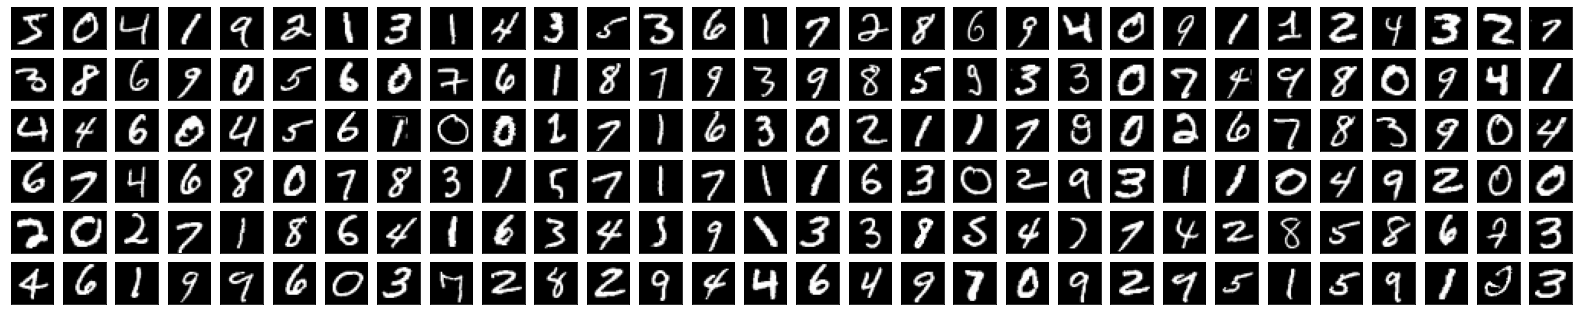

In [16]:
pca.plot(x_train,180,28)

#### 2.3 - Création de la PCA

In [17]:
pca_dataset, vecteurs_propres = pca.PCA(x_train)

Dim => eigenvector = (784, 3)


#### 2.4 -Préparer la visualisation

In [18]:
cols = ['PC%s'%(i+1) for i in range(NUM_COMPENENTS)]
df_prepared = pca.prepare_df_pca(pca_dataset,cols,y_train)
df_prepared.head(4)

PC1         PC2         PC3  target
0  -123.932589 -312.674262  -24.514052       5
1 -1011.718376 -294.857038  596.339561       0
2    51.849608  392.173153 -188.509749       4
3   799.127037 -607.197217  273.651240       1

#### 2.5 - Plot les deux axes PC1 et PC2

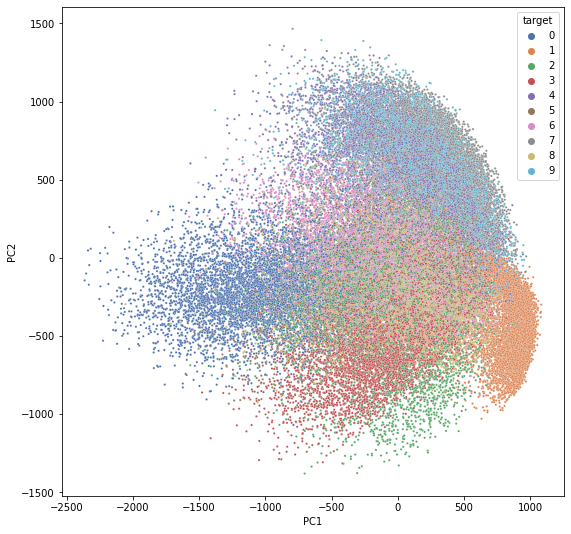

In [19]:
pca.draw_pca(df_prepared,'PC1','PC2',5)

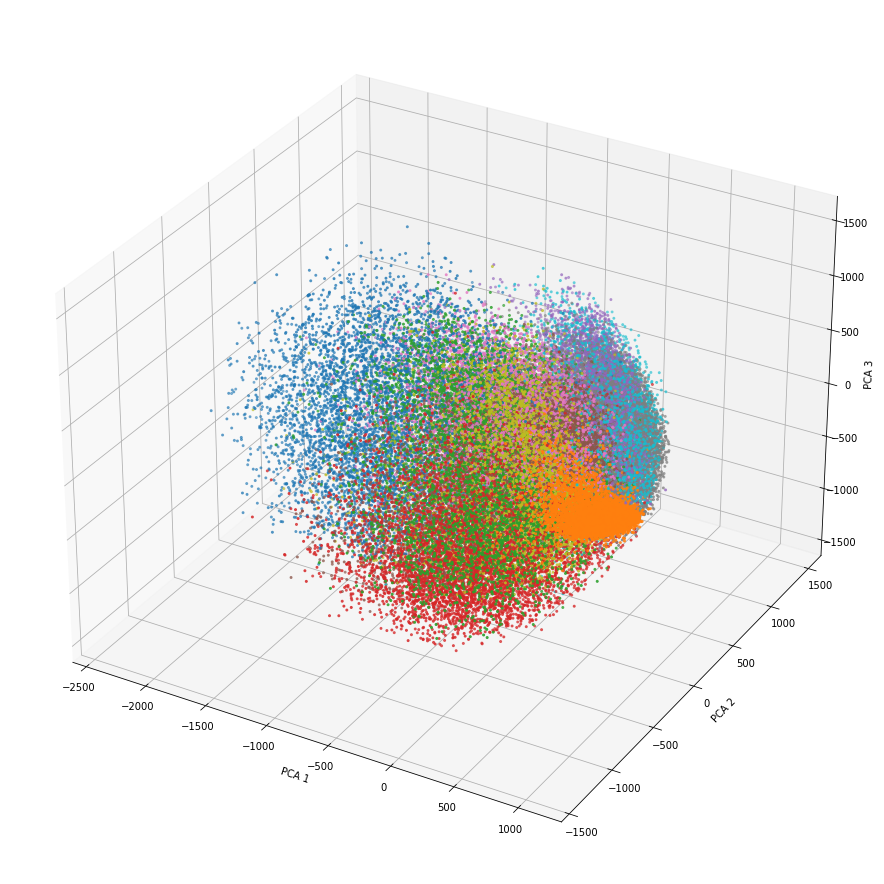

In [20]:
rndperm = np.random.permutation(df_prepared.shape[0])
pca.plot_3D(df_prepared, rndperm)

#### 2.6 - Décoder la PCA : Récupérer des images à partir du plot

In [21]:
decoded_ds = pca.decode(pca_dataset)

In [22]:
decoded_ds.shape

(60000, 784)

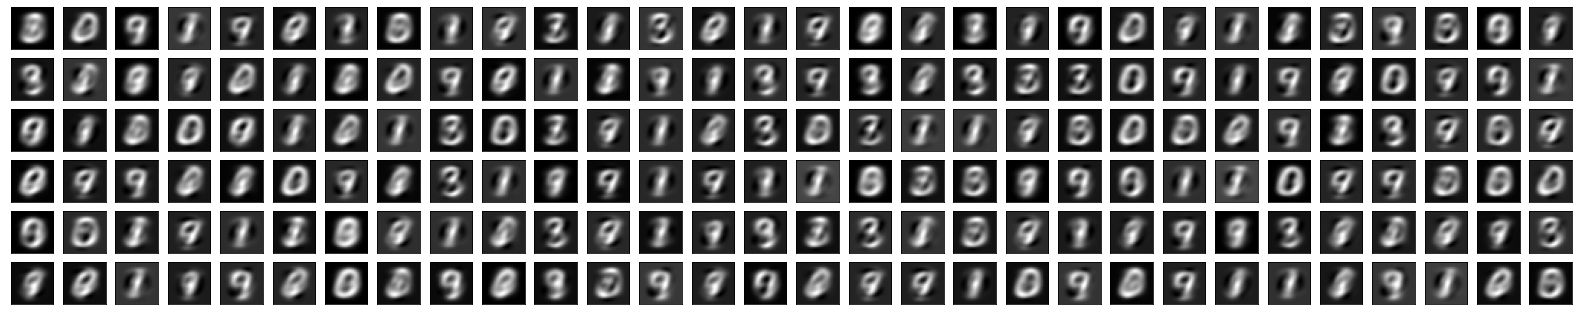

In [23]:
pca.plot(decoded_ds, 180, 28)

#### 2.7 -Test sur PCA de Sklearn

In [24]:
pca_sk = PCA(NUM_COMPENENTS)
pca_result_Mnist = pca_sk.fit_transform(x_train)
pca_result_Mnist.shape

(60000, 3)

In [25]:
cols = ['PC%s'%(i+1) for i in range(NUM_COMPENENTS)]
df_mnist_pca = pd.concat([pd.DataFrame(pca_result_Mnist,columns=cols),pd.DataFrame(y_train,columns=['target'])],axis=1)
df_mnist_pca.head(4)

PC1         PC2         PC3  target
0   123.929600 -312.670351  -24.512287       5
1  1011.720083 -294.852758  596.357437       0
2   -51.850632  392.174168 -188.547068       4
3  -799.127332 -607.198555  273.599755       1

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

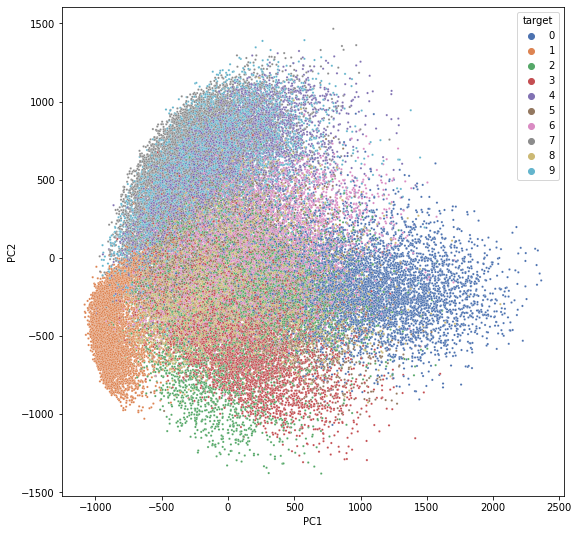

In [26]:
plt.figure(figsize = (9,9))
sb.scatterplot(data = df_mnist_pca , x='PC1',y='PC2' , hue ='target' ,s=5,palette= 'deep')

In [27]:
import os
from PIL import Image
from tqdm import tqdm

In [28]:
PATH = '../../dataset/simpsons_dataset/'
folders = os.listdir(PATH)

In [29]:
def read_image(sample_path:str, resize_to=False):

    im = Image.open(sample_path)
    if resize_to:
        im = im.resize(resize_to)
    im = np.array(im) / 255.0
    im = im.astype("float32")

    return im

In [30]:
def reshape_input(img: np.ndarray):
    
    img.reshape(img.shape[0] * img.shape[1] * img.shape[2]) #
    return img

In [31]:
def read_data_set_simpsons(PATH):
    
    features = []
    targets = []
    for class_id, f in enumerate(folders):
        for im in tqdm(os.listdir(PATH+f)):
            targets.append(class_id+1)
            features.append(reshape_input(read_image(PATH+f+'/'+im, resize_to=(28,28))).flatten())
            
    return np.array(features), np.array(targets)

In [32]:
x_train, y_train = read_data_set_simpsons(PATH)

100%|███████████████████████████████████████████████████████████████████████████████| 181/181 [00:00<00:00, 426.89it/s]


In [33]:
x_train.shape

(20933, 2352)

In [34]:
NUM_COMPENENTS = 7

In [35]:
pca = PCA_MODEL(x_train,NUM_COMPENENTS)

In [36]:
pca_dataset, vecteurs_propres = pca.PCA(x_train)

Dim => eigenvector = (2352, 7)


In [37]:
cols=['PC%s'%(i+1) for i in range(NUM_COMPENENTS)]

df_prepared_simpsons = pca.prepare_df_pca(pca_dataset, cols, y_train)

In [38]:
df_prepared_simpsons.head(4)

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  6.979522 -0.429158  2.282675 -0.628009  2.347215 -2.121450 -0.132496   
1  1.087917  0.053894  1.587904  0.273484 -0.014906  1.763142 -0.288540   
2 -5.954365 -0.196195 -2.301182 -0.808763 -4.934590  4.196906  0.610354   
3 -1.532577 -3.051855 -0.442316  1.361384  0.468780  3.497253 -1.641891   

   target  
0       1  
1       1  
2       1  
3       1

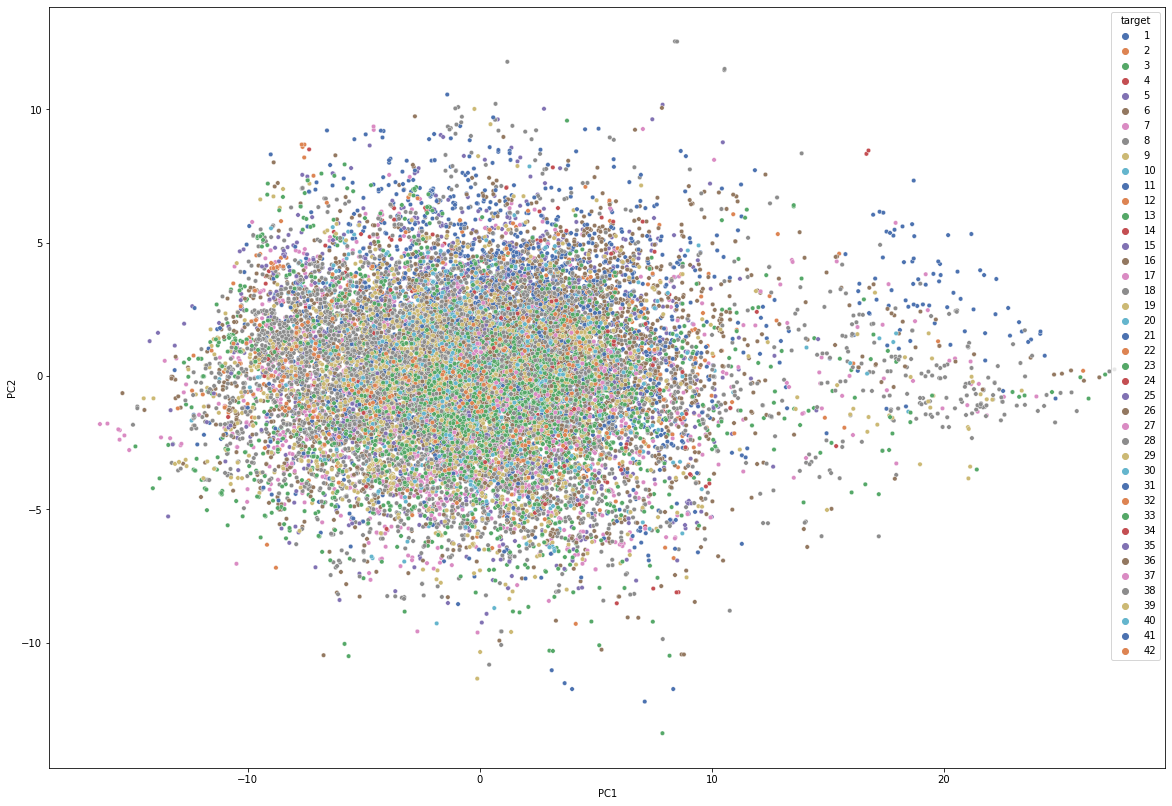

In [39]:
pca.draw_pca(df_prepared_simpsons,'PC1','PC2',20, fig_size=(20,14))

In [40]:
_1d_to_img_ = lambda img : img.reshape((28,28,3))

In [41]:
def redim_img_to_gray_scale(dataset):
    x_train_reshaped = []
    for im in dataset:
        x_train_reshaped.append(_1d_to_img_(im))
    return np.array(x_train_reshaped)[:,:,:,0]

In [42]:
x_train_reshaped = redim_img_to_gray_scale(x_train)
x_train_reshaped.shape

(20933, 28, 28)

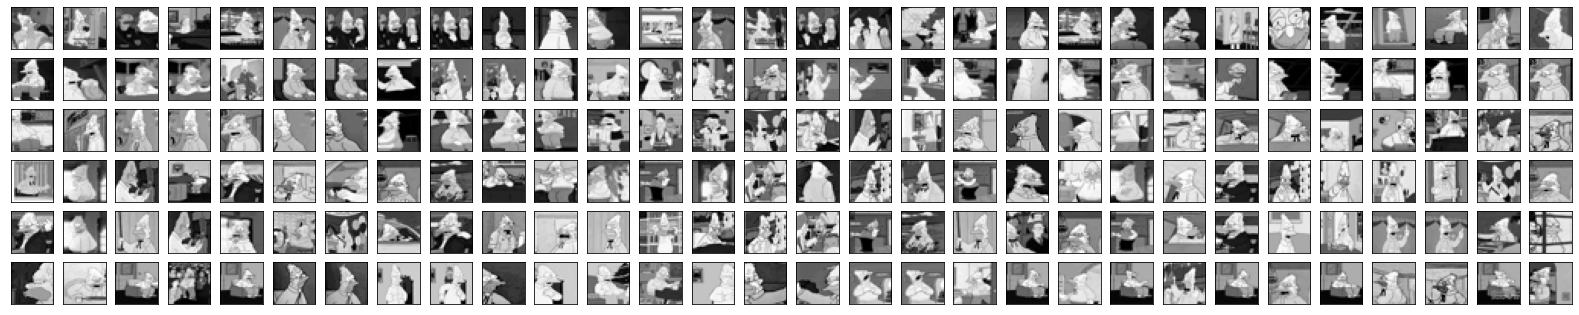

In [43]:
pca.plot(x_train_reshaped,180,28)

In [44]:
decoded_ds = pca.decode(pca_dataset)

In [45]:
decoded_ds.shape

(20933, 2352)

In [46]:
decoded_ds = redim_img_to_gray_scale(decoded_ds)

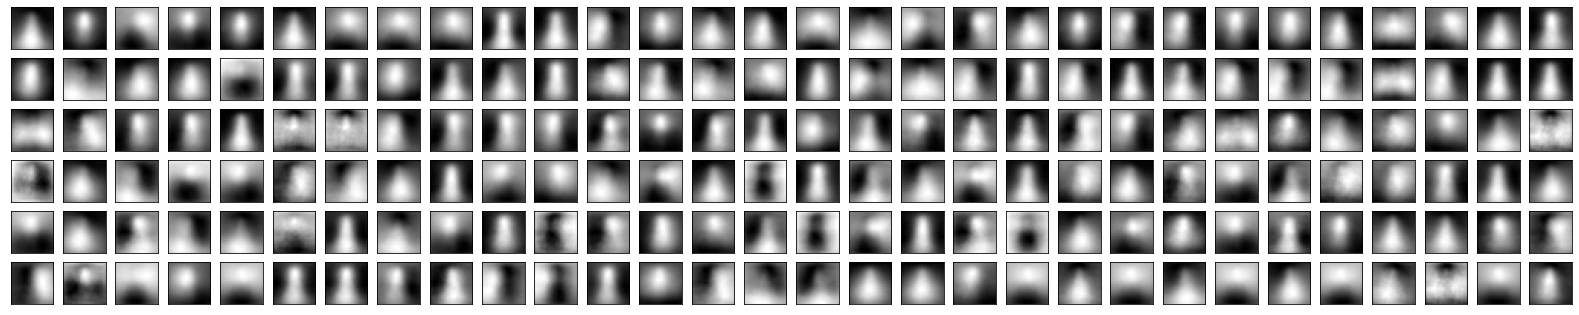

In [47]:
pca.plot(decoded_ds, 180, 28)

#### 2.7 -Test sur PCA de Sklearn

In [48]:
from sklearn.decomposition import PCA
pca_sk = PCA(3)
pca_result_Simp = pca_sk.fit_transform(x_train)
pca_result_Simp.shape

(20933, 3)

In [49]:
cols = ['PC%s'%(i+1) for i in range(3)]
df_simp_pca = pd.concat([pd.DataFrame(pca_result_Simp,columns=cols),pd.DataFrame(y_train,columns=['target'])],axis=1)
df_simp_pca.sample(4)

PC1       PC2       PC3  target
12614  1.314270 -0.448440  1.219232      23
12880  4.416934 -4.746247 -0.935445      23
717   -5.893999  0.721342 -0.912066       1
16065 -2.006848  0.161276 -1.736893      28

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

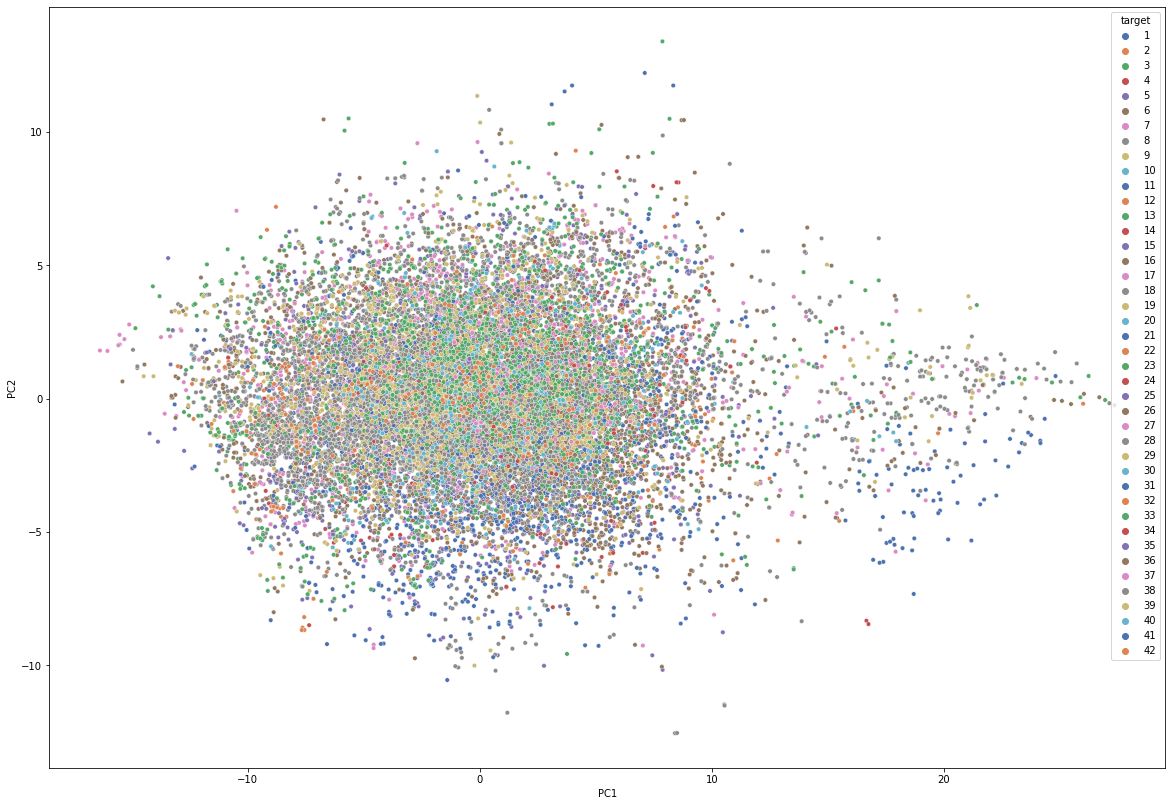

In [50]:
plt.figure(figsize = (20,14))
sb.scatterplot(data = df_simp_pca , x='PC1',y='PC2' , hue ='target' ,s=20,palette= 'deep')